In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
# from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import seaborn as sns
from shapely.geometry import shape, Point, Polygon
import os
import shutil
from pandas.io.json import json_normalize
import geopandas as gpd
import json
from pyproj import Proj, transform

In [85]:
# import shapefile
# # read the shapefile
# reader = shapefile.Reader("./NOR_adm1.shp")
# fields = reader.fields[1:]
# field_names = [field[0] for field in fields]
# buffer = []
# for sr in reader.shapeRecords():
#     atr = dict(zip(field_names, sr.record))
#     geom = sr.shape.__geo_interface__
#     buffer.append(dict(type="Feature", \
#     geometry=geom, properties=atr)) 

# # write the GeoJSON file
# from json import dumps
# geojson = open("NOR_adm1.json", "w")
# geojson.write(dumps({"type": "FeatureCollection",\
# "features": buffer}, indent=2) + "\n")
# geojson.close()


In [17]:
wcs = pd.read_csv('./WHCR_Aerial_Observations_1950_2011.txt', sep = '\t')

In [18]:
wcs.columns

Index([u'Year', u'Month', u'Day', u'Survey_year', u'Coordinates', u'X', u'Y',
       u'WHITE', u'JUVE', u'UNK', u'Band', u'Band_condition', u'Observer',
       u'Pilot', u'Aircraft', u'Area', u'Land_Cover', u'Time', u'Weather',
       u'Temperature', u'Comments'],
      dtype='object')

In [19]:
wc_gp = wcs[['Year','Month','Day','Coordinates','X','Y','WHITE','JUVE','UNK','Band','Time']]

In [37]:
wc_gp['date'] = pd.to_datetime(wc_gp.Year*10000+wc_gp.Month*100+wc_gp.Day,format='%Y%m%d')
# pd.to_datetime(wc_gp.Year, wc_gp.Month, wc_gp.Day)

/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [38]:
wc_gp.head()

,Year,Month,Day,Coordinates,X,Y,WHITE,JUVE,UNK,Band,Time,date
0,1950,10,28,Yes,704249.7827,3.114474e+06,2.0,0.0,0.0,NaN,NaN,1950-10-28
1,1950,11,4,Yes,716924.2997,3.126885e+06,2.0,1.0,0.0,NaN,NaN,1950-11-04
2,1950,11,4,Yes,713611.7098,3.125319e+06,3.0,0.0,0.0,NaN,NaN,1950-11-04
3,1950,11,4,Yes,711590.2891,3.120514e+06,2.0,2.0,0.0,NaN,NaN,1950-11-04
4,1950,11,4,Yes,710267.3697,3.120620e+06,2.0,1.0,0.0,NaN,NaN,1950-11-04


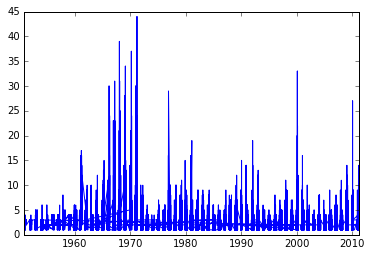

In [39]:
plt.plot(wc_gp['date'], wc_gp['WHITE']+wc_gp['JUVE']+wc_gp['UNK'])

In [32]:
wc_gp.groupby(['Year','Month']).agg('count')

Day  Coordinates    X    Y  WHITE  JUVE  UNK  Band  Time
Year Month                                                          
1950 10       1            1    1    1      1     1    1     0     0
     11      53           53   53   53     53    53   53     0     0
     12      40           40   40   40     40    40   40     0     0
1951 1       34           34   30   30     34    34   34     0     0
     3        9            9    8    8      9     9    9     0     0
     4        2            2    2    2      2     2    2     0     0
     11      22           22   22   22     22    22   22     0     0
     12      19           19   18   18     19    19   19     0     0
1952 1       29           29   29   29     29    29   29     0     0
     2        4            4    4    4      4     4    4     0     0
     3       18           18   18   18     18    18   18     0     0
     10      19           19   19   19     19    19   19     0     0
     11      23           23   23   23     23    23   23     0     0
     12      27           27   27   27     27    27   27     0     3
1953 1       12           12   11   11     12    12   12     0     0
     2        5            5    5    5      5     5    5     0     0
     3       20           20   19   19     20    20   20     0     0
     4       16           16   15   15     16    16   16     0     0
     10       5            5    5    5      5     5    5     0     0
     11      38           38   38   38     38    38   38     0     0
     12      23           23   23   23     23    23   23     0     0
1954 1       10           10   10   10     10    10   10     0     0
     2       22           22   21   21     22    22   22     0     0
     3       20           20   20   20     20    20   20     0     0
     4        8            8    8    8      8     8    8     0     0
     10      12           12   12   12     12    12   12     0     0
     11      39           39   39   39     39    39   39     0     0
     12      27           27   27   27     27    27   27     0     0
1955 2       16           16   15   15     16    16   16     0     0
     3       18           18   18   18     18    18   18     0     0
...         ...          ...  ...  ...    ...   ...  ...   ...   ...
2006 4       97           97   95   95     97    97   97     4    34
     5        6            6    6    6      6     6    6     0     2
     10       4            4    4    4      4     4    4     0     1
     11     366          366  366  366    366   366  366    12   181
     12     192          192  192  192    192   192  192     3    66
2007 1       63           63   63   63     63    63   63     0     3
     2       74           74   72   72     74    74   74     0    18
     3       32           32   32   32     32    32   32     0    22
     4       35           35   35   35     35    35   35     0     4
     11     292          292  292  292    292   292  292     6   147
     12     214          214  214  214    214   214  214     0    90
2008 1       91           91   89   89     91    91   91     0    81
     2      102          102  100  100    102   102  102     0    70
     3      113          113  111  111    113   113  113     0    41
     4       14           14   14   14     14    14   14     0     2
     11     198          198  198  198    198   198  198     0    84
     12     203          203  203  203    203   203  203     0    69
2009 1      220          220  220  220    220   220  220     0   119
     2      194          194  194  194    194   194  194     0    73
     3       74           74   74   74     74    74   74     1    39
     4       67           67   67   67     67    67   67     0    15
     11      41           41   41   41     41    41   41     0     7
     12     183          183  183  183    183   183  183     1    28
2010 1      278          278  278  278    278   278  278     0   104
     2      101          101  101  101    101   101  101     1    35
     3    

In [22]:
wc_2010 = wc_gp[wc_gp['Year']==2010]

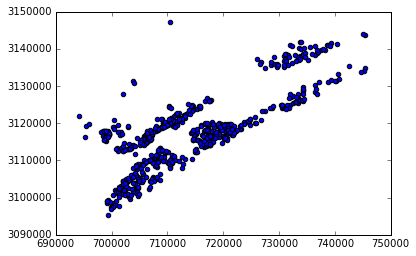

In [27]:
plt.scatter(wc_2010['X'], wc_2010['Y'])
plt.show()

In [28]:
def wc_by_year(year):
    wc_year = wc_gp[wc_gp['Year']==year]
    plt.scatter(wc_year['X'], wc_year['Y'])
    plt.show()

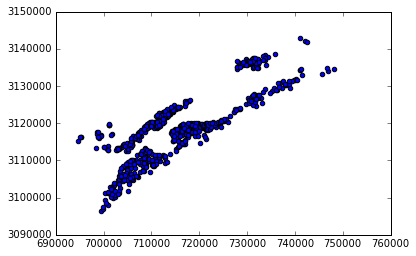

In [31]:
wc_by_year(2007)

In [41]:
import urllib2
from bs4 import BeautifulSoup as bs


page = urllib2.urlopen('http://www.gbif.org/occurrence/search?q=gulo+gulo&year=2015&offset=40')
soup = bs(page.read())

#which of course can be a one-liner if you prefer
# soup = bs(urlopen('string of a real url goes here').read())

/Users/soph/anaconda/envs/py27/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 174 of the file /Users/soph/anaconda/envs/py27/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [74]:
# soup.prettify()
# <tr class="result tableView">
results_table = soup.findAll("tr", { "class" : "result tableView" })
results_table[1]
print(len(results_table))

20


In [71]:
str(results_table[0].td.nextSibling.nextSibling.div.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip()

'61.97N, 12.20E'

In [73]:
str(results_table[0].td.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip().replace(' ','')

'11/2015'

In [281]:
coords = []
dates = []
#2015:1080, 2014:1180, 2013:1180, 2012:980, 2011:1000, 2010:860, 2009:700, 2008:1040

for x in range(0,700,20):
# for x in range(0,60,20):
    page = urllib2.urlopen('http://www.gbif.org/occurrence/search?q=gulo+gulo&year=2009&offset={}'.format(x))
    soup = bs(page.read())
    results_table = soup.findAll("tr", { "class" : "result tableView" })
#     print(results_table[0])
    for i in range(len(results_table)):
        try:
            coords.append(str(results_table[i].td.nextSibling.nextSibling.div.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip())
            dates.append(str(results_table[i].td.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.nextSibling.contents[0]).replace('\n',' ').strip().replace(' ',''))
        except:
            continue

In [282]:
print coords[0].split(',')[1][1:]

20.08E


In [283]:
print len(dates)
print len(coords)

694
694


In [284]:
lat = []
lng = []
for i in range(len(coords)):
#     print coords[i]
    if len(coords[i].split(','))==2:
        lat.append(coords[i].split(',')[0][:-1])
        lng.append(coords[i].split(',')[1][1:-1])
    else:
        lat.append(0)
        lng.append(0)

In [285]:
lat = np.array(lat)
lng = np.array(lng)
dates = np.array(dates)

In [286]:
wolv_data = pd.DataFrame(np.vstack((lat,lng,dates)).T, columns=['lat','lng','dates'])

In [287]:
wolv_data['lng'] = pd.to_numeric(wolv_data['lng'])
wolv_data['lat'] = pd.to_numeric(wolv_data['lat'])
wolv_data['dates'] = pd.to_datetime(wolv_data['dates'])

In [288]:
wolv_data = wolv_data[(wolv_data['lng']<=40) & (wolv_data['lat']>=50)]

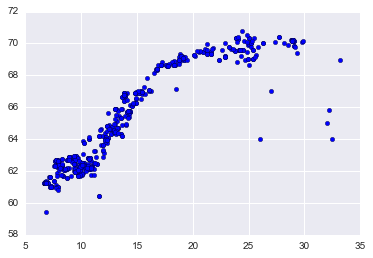

In [4]:
plt.scatter(wolv_data['lng'].values.astype('float64'),wolv_data['lat'].values.astype('float64'))

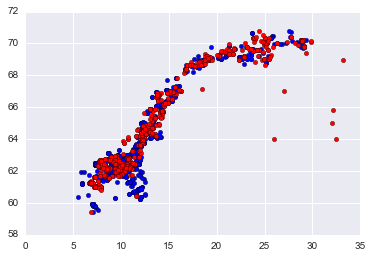

In [11]:
plt.scatter(wolv_data['lng'].values.astype('float64'),wolv_data['lat'].values.astype('float64'))
plt.scatter(wolv_data_2['lng'].values.astype('float64'),wolv_data_2['lat'].values.astype('float64'), c='r')

In [101]:
wolv_data = pd.read_csv('./wolv_2015.csv')
# wolv_data = wolv_data.drop(['Unnamed: 0'], axis=1)
wolv_data.head()

,lat,lng,dates
0,61.79,9.93,9/2015
1,61.77,10.11,9/2015
2,61.33,11.10,4/2015
3,69.11,20.11,12/2015
4,69.31,21.21,12/2015


In [36]:
# wolv_data.to_csv('./wolv_2015.csv', index=False)

In [12]:
wolv_data['dates'] = pd.to_datetime(wolv_data['dates'])

In [14]:
wolv_data['month'] = wolv_data.apply(lambda row: row['dates'].month, axis=1)

In [18]:
np.sort(wolv_data.month.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

IndexError: list index out of range

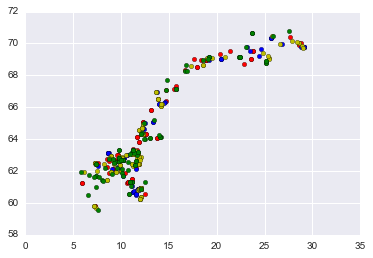

In [19]:
colors=['k','r','b','y','g']
for i in np.sort(wolv_data.month.unique())[:5]:
    plt.scatter(wolv_data[wolv_data['month']==i]['lng'].values.astype('float64'),wolv_data[wolv_data['month']==i]['lat'].values.astype('float64'), c=colors[i])

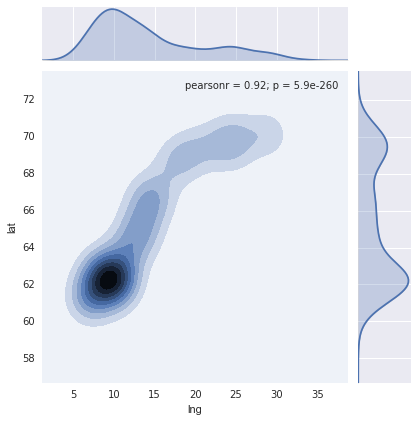

In [291]:
sns.jointplot(x="lng", y="lat", data=wolv_data, kind="kde");

In [254]:
x_grid = np.linspace(np.min(wolv_data['lng']),np.max(wolv_data['lng']),50)
y_grid = np.linspace(np.min(wolv_data['lat']),np.max(wolv_data['lat']),50)
X,Y = np.meshgrid(x_grid, y_grid)

In [255]:
eval_pts = np.vstack((X.flatten(), Y.flatten()))

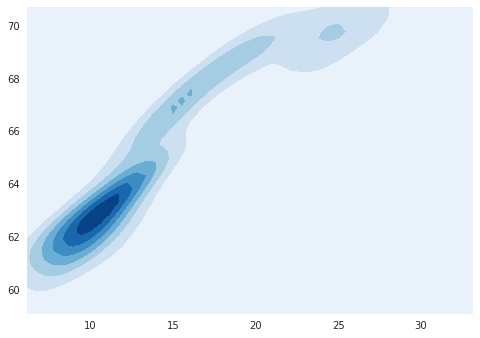

In [256]:
scipy_kde = gaussian_kde(wolv_data[['lng','lat']].T)
values = scipy_kde.evaluate(eval_pts)
cmap = plt.cm.get_cmap("Blues")
plt.contourf(X,Y, values.reshape(50,50), cmap=cmap)

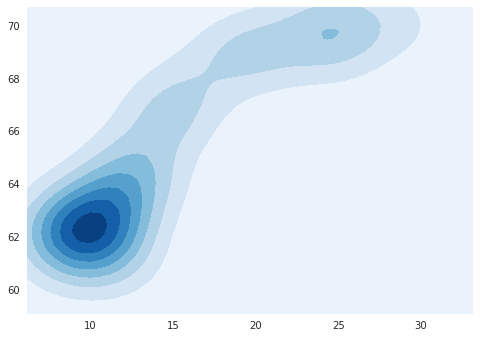

In [257]:
statsmodel_kde = KDEMultivariate(wolv_data[['lng','lat']], var_type='cc')
values = statsmodel_kde.pdf(eval_pts)
plt.contourf(X,Y, values.reshape(50,50), cmap=cmap)

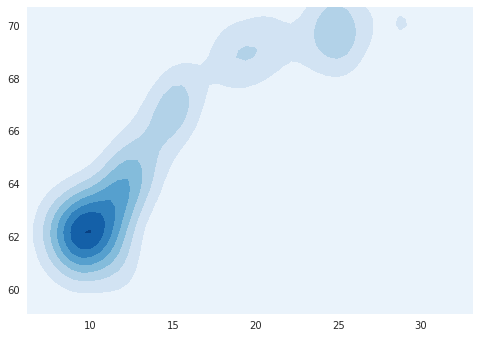

In [258]:
sklearn_kde = KernelDensity()
sklearn_kde.fit(wolv_data[['lng','lat']])
log_values = sklearn_kde.score_samples(eval_pts.T)
values = np.exp(log_values)
plt.contourf(X,Y, values.reshape(50,50), cmap=cmap)

In [87]:
regions2 = gpd.read_file('./NOR_adm1.json')
regions2.shape

(19, 13)

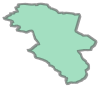

In [94]:
regions2['geometry'][5]

In [105]:
wolv_data[['lat','lng']].values[0][0]

61.789999999999999

In [150]:
names = []
counts = []
for j in range(len(regions2)):
    count = 0
    for i in range(len(wolv_data[['lat','lng']].values)):
        if regions2['geometry'][j].contains(Point(wolv_data[['lat','lng']].values[i][1],wolv_data[['lat','lng']].values[i][0])):
            count+=1
    print regions2['NAME_1'][j], count
    names.append(regions2['NAME_1'][j])
    counts.append(count)


Ãstfold 0
Akershus 0
Aust-Agder 2
Buskerud 2
Finnmark 65
Hedmark 154
Hordaland 28
Møre og Romsdal 86
Nord-Trøndelag 110
Nordland 143
Oppland 218
Oslo 0
Rogaland 0
Sør-Trøndelag 165
Sogn og Fjordane 28
Telemark 5
Troms 58
Vest-Agder 0
Vestfold 0


In [165]:
pop_data['County'] = pop_data.apply(lambda row: row['County'].encode('utf-8'), axis=1)

In [192]:
nature_data['County'] = nature_data.apply(lambda row: row['County'].encode('utf-8') if type(row['County'])=='unicode' else row['County'], axis=1)

In [171]:
populations = []
for i in range(len(names)):
    pop = pop_data[pop_data['County']==maptostats[names[i]]]['2015K1'].values
    print(int(pop[0]))
    populations.append(int(pop[0]))

287198
584899
114767
274737
75605
195153
511357
263719
135738
241682
188807
647676
466302
310047
109170
171953
163453
180877
242662


In [211]:
for i in range(1,len(nature_data['County'])):
    print nature_data['County'][i][3]

f
f
f
f
f
r
r
r
r
r
o
o
o
o
o
m
m
m
m
m
l
l
l
l
l
k
k
k
k
k
t
t
t
t
t
e
e
e
e
e
t
t
t
t
t
t
t
t
t
t
a
a
a
a
a
d
d
d
d
d
g
g
g
g
g
n
n
n
n
n
e
e
e
e
e
-
-
-
-
-
d
d
d
d
d
d
d
d
d
d
m
m
m
m
m
n
n
n
n
n
e
b
1
r
3
t
t
t
 
h
t
l
b
 


In [222]:
greenspace = []
for i in range(len(names)):
    vals = nature_data[nature_data['County'].str.contains(maptostats[names[i]])>0]['2015'].values
    try:
        print maptostats[names[i]], [float(vals[i]) for i in range(1,5)]
    except:
        print maptostats[names[i]], [float(vals[i]) for i in range(2,5)]
#     print(int(pop[0]))
#     populations.append(int(pop[0]))

 stfold [14.89, 133.66, 21.73, 0.5]
Akershus Akershus [167.79, 31.87, 1.42]
Aust-Agder Akershus [262.78, 1602.83, 33.22]
Buskerud [1196.98, 410.85, 410.59, 0.18]
Finnmark [4388.74, 441.12, 619.85, 0.34]
Hedmark [1124.32, 1117.97, 1339.55, 0.07]
Hordaland [2453.93, 88.03, 575.29, 6.78]
og Romsdal [1188.87, 218.22, 2519.2, 241.15]
Nord-Tr [2933.67, 875.27, 99.04, 10.94]
Nordland [5601.4, 748.82, 872.35, 4.51]
Oppland [5606.59, 569.78, 1464.6, 4.6]
Oslo Akershus [9.21, 30.78, 0.09]
Rogaland Akershus [67.15, 1047.13, 36.37]
r-Tr [1690.37, 410.68, 1580.49, 2.27]
Sogn og Fjordane [2047.19, 179.23, 1857.72, 3.73]
Telemark [769.96, 312.13, 696.54, 33.55]
Troms [2252.79, 151.74, 1591.17, 1.87]
Vest-Agder Akershus [61.95, 878.12, 4.4]
Vestfold [15.22, 28.13, 6.86, 1.42]


In [185]:
nature_data = pd.read_csv('./20174241432533613544566VernetAreal.csv', delimiter=';', skiprows=1, encoding='cp865')
nature_data['County'] = nature_data['County'].replace(to_replace=' ', value=np.nan)
nature_data['County'] = nature_data['County'].fillna(method='ffill')
nature_data.head(30)

,County,Unnamed: 1,1997,1998,1999,2000,2001,2002,2003,2004,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,NaN,,Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),...,Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓),Protected area (km▓)
1,╪stfold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,╪stfold,National parks,..,0.00,0.00,..,..,..,0.00,..,...,..,..,..,14.77,14.77,14.70,14.69,14.69,14.91,14.89
3,╪stfold,Nature reserves,..,67.78,67.78,..,..,..,69.22,..,...,74.19,74.19,77.65,78.06,89.14,88.89,88.87,116.76,129.69,133.66
4,╪stfold,Landscape protected areas,..,10.95,10.95,..,..,..,10.17,..,...,10.17,10.17,10.17,10.18,16.40,16.40,16.39,21.72,21.72,21.73
5,╪stfold,Other protections,..,0.00,0.00,..,..,..,0.00,..,...,0.06,0.06,0.07,0.35,0.33,0.32,0.51,0.51,0.50,0.50
6,Akershus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Akershus,National parks,..,0.00,0.00,..,..,..,0.00,..,...,..,..,..,..,..,..,..,..,..,..
8,Akershus,Nature reserves,..,104.20,104.20,..,..,..,123.52,..,...,120.86,121.11,133.43,133.45,139.48,140.56,122.69,155.61,157.83,167.79
9,Akershus,Landscape protected areas,..,28.68,28.68,..,..,..,60.20,..,...,29.46,29.46,32.50,32.50,32.50,32.50,32.40,32.48,32.49,31.87


In [72]:
# from shapely.ops import transform

# scale = [0.0026528888734561784,0.0013213361467212163]
# translate=[4.644156880854525,57.97359915609933]
# g2 = transform(lambda x, y, z=None: (x*scale[0]+translate[0], y*scale[1]+translate[1]), regions['geometry'][0])

In [173]:
pop_data = pd.read_csv('./20174241429501913544566Rd1222Kv.csv', delimiter=';', skiprows=1, encoding='cp865')
pop_data.head()

,County,1997K4,1998K1,1998K2,1998K3,1998K4,1999K1,1999K2,1999K3,1999K4,...,2014K3,2014K4,2015K1,2015K2,2015K3,2015K4,2016K1,2016K2,2016K3,2016K4
0,,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,...,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter,Population at the beginning of the quarter
1,╪stfold,243230,243585,243950,244663,245551,246018,246133,246949,247825,...,286113,286781,287198,287561,288520,289178,289867,290412,291562,292127
2,Akershus,451961,453490,454811,456635,459216,460564,462053,463445,465889,...,581225,583325,584899,586860,590106,592512,594533,596704,599608,601789
3,Oslo,499496,499693,501434,502113,502535,502867,504291,505400,506825,...,640313,645701,647676,650733,652044,656614,658390,660987,662587,666691
4,Hedmark,186141,186118,186043,186064,186326,186321,186221,186345,187012,...,194723,195039,195153,195155,195408,195392,195356,195443,195678,195942


In [159]:
for i in range(len(pop_data.County)):
    print pop_data.County[i].encode('utf-8')

 
╪stfold
Akershus
Oslo
Hedmark
Oppland
Buskerud
Vestfold
Telemark
Aust-Agder
Vest-Agder
Rogaland
Hordaland
Sogn og Fjordane
M°re og Romsdal
S°r-Tr°ndelag
Nord-Tr°ndelag
Nordland
Troms - Romsa
Finnmark - Finnmßrku
Figures for 2012K4 were correced 21 February 2013 at 13:00. 
For the 4th quarter the increase in population is calculated as the 
population at the end of the year less the population at the start of 
the quarter. For the first, second and third quarter the increase in 
population is the sum of the excess of births and the net migration.


In [161]:
for i in range(len(regions2['NAME_1'])):
    print regions2['NAME_1'][i].encode('utf-8')

Ãstfold
Akershus
Aust-Agder
Buskerud
Finnmark
Hedmark
Hordaland
Møre og Romsdal
Nord-Trøndelag
Nordland
Oppland
Oslo
Rogaland
Sør-Trøndelag
Sogn og Fjordane
Telemark
Troms
Vest-Agder
Vestfold


In [212]:
maptostats = dict()
for i in range(len(regions2['NAME_1'])):
    for j in range(len(pop_data.County)):
        if regions2['NAME_1'][i]==pop_data.County[j]:
            maptostats[regions2['NAME_1'][i]] = pop_data.County[j]
maptostats[names[0]] = 'stfold'
maptostats[names[7]] = 'og Romsdal'
maptostats[names[8]] = 'Nord-Tr'
maptostats[names[13]] = 'r-Tr'
maptostats[names[16]] = 'Troms'
maptostats[names[4]] = 'Finnmark'

In [156]:
for i in range(len(names)):
    print i, names[i]

0 Ãstfold
1 Akershus
2 Aust-Agder
3 Buskerud
4 Finnmark
5 Hedmark
6 Hordaland
7 Møre og Romsdal
8 Nord-Trøndelag
9 Nordland
10 Oppland
11 Oslo
12 Rogaland
13 Sør-Trøndelag
14 Sogn og Fjordane
15 Telemark
16 Troms
17 Vest-Agder
18 Vestfold


In [213]:
maptostats

{u'Akershus': u'Akershus',
 u'Aust-Agder': u'Aust-Agder',
 u'Buskerud': u'Buskerud',
 u'Finnmark': 'Finnmark',
 u'Hedmark': u'Hedmark',
 u'Hordaland': u'Hordaland',
 u'M\xf8re og Romsdal': 'og Romsdal',
 u'Nord-Tr\xf8ndelag': 'Nord-Tr',
 u'Nordland': u'Nordland',
 u'Oppland': u'Oppland',
 u'Oslo': u'Oslo',
 u'Rogaland': u'Rogaland',
 u'Sogn og Fjordane': u'Sogn og Fjordane',
 u'S\xf8r-Tr\xf8ndelag': 'r-Tr',
 u'Telemark': u'Telemark',
 u'Troms': 'Troms',
 u'Vest-Agder': u'Vest-Agder',
 u'Vestfold': u'Vestfold',
 u'\xc3stfold': 'stfold'}

In [226]:
from functools import partial
import pyproj
for i in range(len(names)):
    
    geom = regions2['geometry'][i]
    geom_aea = transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat1=geom.bounds[1],
            lat2=geom.bounds[3])),
    geom)

    print(regions2['NAME_1'][i], geom_aea.area)

(u'\xc3stfold', 4209916943.0132656)
(u'Akershus', 4941877724.047725)
(u'Aust-Agder', 9223150212.018366)
(u'Buskerud', 14892328300.994389)
(u'Finnmark', 48809322353.38257)
(u'Hedmark', 27453755979.089214)
(u'Hordaland', 15582447922.946806)
(u'M\xf8re og Romsdal', 15185477040.161474)
(u'Nord-Tr\xf8ndelag', 22722258951.99965)
(u'Nordland', 38653786765.04209)
(u'Oppland', 25155444930.325787)
(u'Oslo', 454737135.826888)
(u'Rogaland', 9274735252.68322)
(u'S\xf8r-Tr\xf8ndelag', 19000053726.481133)
(u'Sogn og Fjordane', 18643796648.24592)
(u'Telemark', 15314158921.163599)
(u'Troms', 25943271665.53906)
(u'Vest-Agder', 7414299750.234486)
(u'Vestfold', 2248147154.0828805)
